<center> <h1> Homework 2 – Machine Learning Pipeline <h1> </center>
### Goal:
The goal of this assignment is to build a simple, modular, extensible, machine learning
pipeline in Python. The pipeline should have functions that can do the following tasks:
1. Read/Load Data
2. Explore Data
3. Pre-Process and Clean Data
4. Generate Features/Predictors
5. Build Machine Learning Classifier
6. Evaluate Classifier

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm
import statsmodels.api as sm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score

C:\Users\roseg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# Supress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [5]:
def load_data(filename, verbose=False):
    df = pd.read_csv(filename, index_col=0)
    if verbose:
        print('Dataset shape:', df.shape)
        print('Dataset columns:', df.columns)
        print('Dataset types:', df.dtypes)
        print('')
    return df

In [4]:
def load_data_dictionary(filename):
    df = pd.read_excel('GiveMeSomeCredit/Data%20Dictionary.xls')
    pd.set_option('display.max_colwidth', -1)
    return df

In [5]:
load_data_dictionary('GiveMeSomeCredit/Data%20Dictionary.xls')

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


## 2. Explore Data

#### Check target variable distribution
If target variable is skewed, the regression predictions will be similarly skewed. If skewed, transform the target variable.

In [94]:
def histogram(df, target, bins, xmin, xmax, ymin, ymax):
    '''
    Create histogram of target variable
    '''
    plt.figure(figsize=(7,5))
    n, bins, patches = plt.hist(df[target], bins=bins, alpha=0.75, color='grey')
    
    # plot histogram
    plt.xlabel(target)
    plt.ylabel('Probability')
    plt.title('Histogram of ' + target)
    plt.axis([xmin, xmax, ymin, ymax])
    plt.grid(True)
    plt.show()   

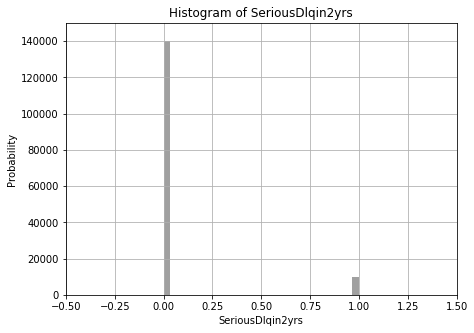

In [93]:
histogram(train_df, 'SeriousDlqin2yrs', bins=30, xmin=-0.5, xmax=1.5, ymin=0, ymax=150000)

Skip next two cells if target variable is not skewed.

In [266]:
# def create_log_target(target, xmin, xmax, ymin, ymax):
#     # fit the normal distribution on log target
#     mu, sigma = norm.fit(np.log(target))

#     # create histogram of log target
#     plt.figure(figsize=(7,5))
#     n, bins, patches = plt.hist(np.log(target), bins=60, normed=True, alpha=0.75, color='Grey')

#     # add fitted line
#     y = mlab.normpdf(bins, mu, sigma)
#     l = plt.plot(bins, y, 'g--', linewidth=2)

#     # plot histogram
#     plt.xlabel('Log Target')
#     plt.ylabel('Probability')
#     plt.title('Histogram of Log Target: mu = {}, sigma = {}'.format(round(mu, 2), round(sigma, 2)))
#     plt.axis([xmin, xmax, ymin, ymax])
#     plt.grid(True)
#     plt.show()

In [267]:
# create_log_target(target, 4.5, 11, 0, 0.5)

In [102]:
# # if log target is better:
# def log_target(df):
#     target = df.iloc[:,0]
#     df['log_target'] = np.log(target)
#     df = df.drop(target)
#     return df

#### Check Correlation

In [151]:
def create_correlation_heatmap(df):
    # compute correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # create figure and plot
    fig = plt.figure(figsize=(len(cont_feats), 5)) 
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 10, as_cmap=True))
    plt.show()

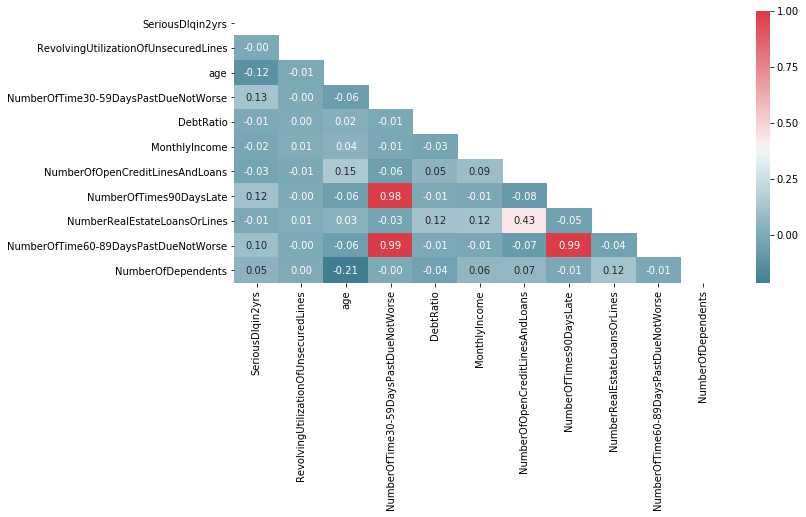

In [152]:
create_correlation_heatmap(train_df)

It looks like there's a 0.98 or 0.99 correlation between:
- Number of Time 30-59 Days Past Due Not Worse and Number of Time 60-89 Days Past Due Not Worse
- Number of Time 30-59 Days Past Due Not Worse and Number of Time 90 Days Late
- Number of Time 60-89 Days Past Due Not Worse and Number of Time 90 Days Late

We can try dropping 'NumberOfTime30-59DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'.

In [6]:
def drop_correlated_variables(df, correlated_variables):
    df = df.drop(correlated_variables, axis=1)
    return df

## 3. Pre-Process and Clean Data

### Check that values make sense

RevolvingUtilizationOfUnsecuredLines and DebtRatio are percentages. Let's make sure that the values are between 0 and 1.

#### Revolving Utilization Of Unsecured Lines

In [153]:
train_df['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean     6.048438     
std      249.755371   
min      0.000000     
25%      0.029867     
50%      0.154181     
75%      0.559046     
max      50708.000000 
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

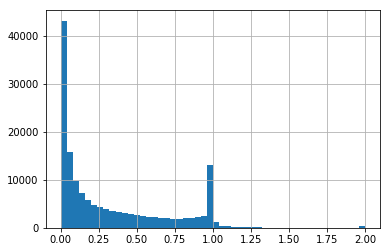

In [154]:
train_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x:min(2.0,x)).hist(bins=50)

Text(0,0.5,'Default')

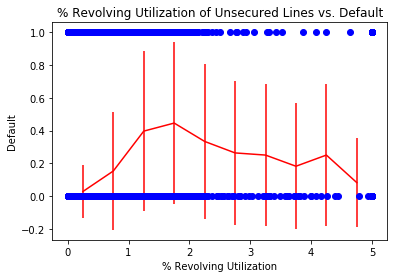

In [155]:
x = train_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x:min(5.0,x))
y = train_df['SeriousDlqin2yrs']
nbins = 10

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y**2)
mean = sy/n
std = np.sqrt(sy2/n - mean*mean)

plt.plot(x, y, 'bo')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')
plt.title('% Revolving Utilization of Unsecured Lines vs. Default')
plt.xlabel('% Revolving Utilization')
plt.ylabel('Default')

In [156]:
sm.Logit(endog=train_df['SeriousDlqin2yrs'], exog=train_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x:min(5.0,x))
).fit().summary()

Optimization terminated successfully.
         Current function value: 0.561587
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               150000
Model:                          Logit   Df Residuals:                   149999
Method:                           MLE   Df Model:                            0
Date:                Sun, 15 Apr 2018   Pseudo R-squ.:                  -1.289
Time:                        16:09:16   Log-Likelihood:                -84238.
converged:                       True   LL-Null:                       -36808.
                                        LLR p-value:                       nan
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
RevolvingUtilizationOfUnsecuredLines    -2.8421      0.019   -150.206      0.000      -2.879      -2.805
========================================================================================================
"""

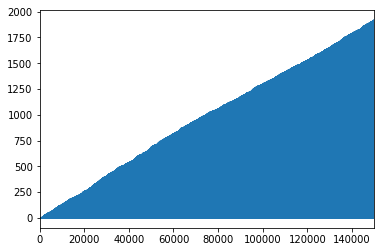

In [157]:
train_df.groupby('RevolvingUtilizationOfUnsecuredLines')['SeriousDlqin2yrs'].cumsum().plot()

Based on the previous graphs, I'm deciding to cap 'RevolvingUtilizationOfUnsecuredLines' at 5.

#### Debt Ratio

In [317]:
train_df['RevolvingUtilizationOfUnsecuredLines'] = train_df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: min(5.0, x))

In [159]:
train_df['DebtRatio'].describe()

count    150000.000000
mean     353.005076   
std      2037.818523  
min      0.000000     
25%      0.175074     
50%      0.366508     
75%      0.868254     
max      329664.000000
Name: DebtRatio, dtype: float64

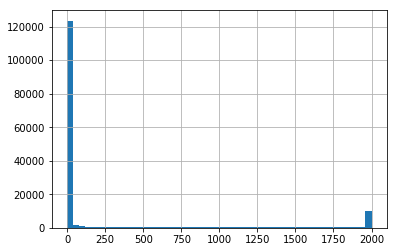

In [160]:
train_df['DebtRatio'].apply(lambda x: min(2000, x)).hist(bins=50)

Text(0,0.5,'Default')

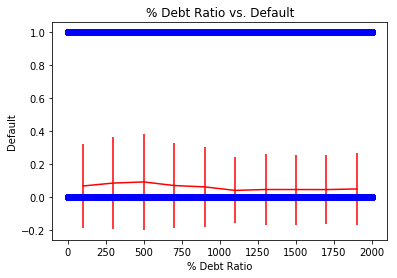

In [161]:
x = train_df['DebtRatio'].apply(lambda x: min(2000.0, x))
y = train_df['SeriousDlqin2yrs']
nbins = 10

n, _ = np.histogram(x, bins=nbins)
sy, _ = np.histogram(x, bins=nbins, weights=y)
sy2, _ = np.histogram(x, bins=nbins, weights=y**2)
mean = sy/n
std = np.sqrt(sy2/n - mean*mean)

plt.plot(x, y, 'bo')
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-')
plt.title('% Debt Ratio vs. Default')
plt.xlabel('% Debt Ratio')
plt.ylabel('Default')

Based on the previous graphs, I'm deciding to cap 'DebtRatio' at 2000.

In [318]:
train_df['DebtRatio'] = train_df['DebtRatio'].apply(lambda x: min(2000.0, x))

In [50]:
def cap_outliers(df, outliers):
    for outlier, cap in outliers:
        df[outlier] = df[outlier].apply(lambda x: min(cap, x))
    return df

### Outlier Detection

In [7]:
def iqr_outlier(var):
    q1, q3 = np.percentile(var, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - (iqr * 1.5)
    upper_fence = q3 + (iqr * 1.5)
    return np.where((var > upper_fence) | (var < lower_fence))

#### Age

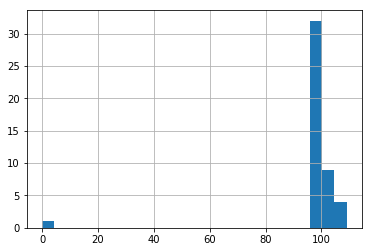

In [164]:
train_df.iloc[iqr_outlier(train_df['age'])]['age'].hist(bins=25)

Someone is age 0 - let's find that person and fix it.

In [326]:
# replace age = 0 with median age
mask = train_df['age'] == 0
train_df.loc[mask, 'age'] = train_df['age'].median()

#### Number Of Time 60-89 Days Past Due Not Worse

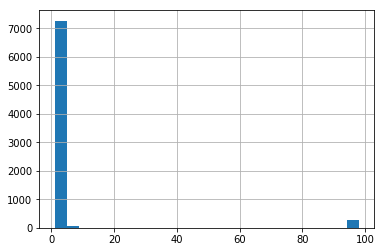

In [166]:
train_df.iloc[iqr_outlier(train_df['NumberOfTime60-89DaysPastDueNotWorse'])]['NumberOfTime60-89DaysPastDueNotWorse'].hist(bins=25)

In [184]:
train_df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

0     142665
1     5731  
2     1118  
3     318   
4     105   
5     34    
6     16    
7     9     
8     2     
11    1     
9     1     
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

There are 264 people 98 times 60-89 days past due, and 5 people with 96 times 60-89 days past due. I'm going to assume that these are errors (or a code for unknown) and replace them with 0.

In [327]:
# replace NumberOfTime60-89DaysPastDueNotWorse > 95 with 0
mask = train_df['NumberOfTime60-89DaysPastDueNotWorse'] > 95
train_df.loc[mask, 'NumberOfTime60-89DaysPastDueNotWorse'] = 0

#### Likewise, replace other 'Past Due' outliers

In [16]:
train_df['NumberOfTime30-59DaysPastDueNotWorse'].unique()

array([ 2,  0,  1,  3,  4,  5,  7, 10,  6, 98, 12,  8,  9, 96, 13, 11], dtype=int64)

In [328]:
mask = train_df['NumberOfTime30-59DaysPastDueNotWorse'] > 95
train_df.loc[mask, 'NumberOfTime30-59DaysPastDueNotWorse'] = 0

In [17]:
train_df['NumberOfTimes90DaysLate'].unique()

array([ 0,  1,  3,  2,  5,  4, 98, 10,  9,  6,  7,  8, 15, 96, 11, 13, 14,
       17, 12], dtype=int64)

In [329]:
mask = train_df['NumberOfTimes90DaysLate'] > 95
train_df.loc[mask, 'NumberOfTimes90DaysLate'] = 0

#### Deal with Missing Values

Depending on the model, it may be better to fill missing values with an average (mean/median) or a different value like -1.

In [193]:
# check for missing values
print('% of rows with missing values:', round(len(train_df[train_df.isnull().any(axis=1)])/len(train_df),3)*100)

% of rows with missing values: 0.0


In [194]:
# check which columns have missing values
train_df.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

I have a few choices for filling in missing values. However, in this case, an unknown monthly income and unknown number of dependents can be reasonably filled with 0.

In [11]:
def fill_na_with_zero(df):
    df2 = df.copy(deep=True)
    null_vars = list(df2.columns[df2.isnull().any()])
    for i in null_vars:
        df2[i] = df2[i].fillna(0)
    return df2

In [12]:
def fill_na_with_median(df):
    df2 = df.copy(deep=True)
    null_vars = list(df.columns[df2.isnull().any()])
    for i in null_vars:
        df2[i] = df2[i].fillna(df2[i].median())
    return df2

In [13]:
def fill_na_with_neg_one(df):
    df2 = df.copy(deep=True)
    null_vars = list(df2.columns[df2.isnull().any()])
    for i in null_vars:
        df2[i] = df2[i].fillna(-1)
    return df2

### 4. Generate Features/Predictors

#### Convert Categorical Features to Binary Features

In [96]:
# def one_hot_encoding_categorical(df, target):
#     # separate out categorical features
#     cat_feats = [x for x in df.select_dtypes(include=['object']).columns if x not in [target]]
    
#     # one hot encoding for categorical features
#     binary_feats = pd.get_dummies(df[cat_feats])

#     # concatenate binary features
#     df = pd.concat([df, binary_feats], axis=1)
#     df = df.drop(cat_feats, axis=1)
#     return df

#### Train Test Split

In [21]:
def split_data(df, target, test_size=0.3):
    y = df[target] # or np.log(df[target])
    X = df.drop([target], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    print('X train shape:', X_train.shape)
    print('y train shape:', y_train.shape)
    print('X test shape:', X_test.shape)
    print('y test shape:', y_test.shape)
    return X_train, X_test, y_train, y_test

#### Simple X and y Split

In [ ]:
# def x_y_split(df, target):
#     y = df[target] # or np.log(df[target])
#     X = df.drop([target], axis=1)
#     return X, y

### 5. Build Machine Learning Classifiers

In [14]:
ridge = linear_model.RidgeClassifier()

In [16]:
decision_tree = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10)

### 6. Evaluate Classifier

In [22]:
def calculate_cv(model, X_train, y_train, n_splits=10, seed=8):
    kfold = KFold(n_splits, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('Model average score:', round(scores.mean(), 3))

#### Fill NA with 0

In [97]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv', verbose=True)
train_df = fill_na_with_zero(train_df)

Dataset shape: (150000, 11)
Dataset columns: Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')
Dataset types: SeriousDlqin2yrs                        int64  
RevolvingUtilizationOfUnsecuredLines    float64
age                                     int64  
NumberOfTime30-59DaysPastDueNotWorse    int64  
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans         int64  
NumberOfTimes90DaysLate                 int64  
NumberRealEstateLoansOrLines            int64  
NumberOfTime60-89DaysPastDueNotWorse    int64  
NumberOfDependents                      float64
dtype: object



In [34]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 10)
y train shape: (105000,)
X test shape: (45000, 10)
y test shape: (45000,)


In [35]:
calculate_cv(ridge, X_train, y_train)

Model average score: 0.933


In [36]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.936


#### Fill N/A with median

In [37]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv')
train_df = fill_na_with_median(train_df)

In [38]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 10)
y train shape: (105000,)
X test shape: (45000, 10)
y test shape: (45000,)


In [39]:
calculate_cv(ridge, X_train, y_train)

Model average score: 0.933


In [40]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.935


#### Fill N/A with -1

In [41]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv')
train_df = fill_na_with_neg_one(train_df)

In [42]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 10)
y train shape: (105000,)
X test shape: (45000, 10)
y test shape: (45000,)


In [43]:
calculate_cv(ridge, X_train, y_train)

Model average score: 0.933


In [44]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.936


#### Fill NA with 0 & Drop Correlated Variables 'NumberOfTime30-59DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'

In [65]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv')
train_df = fill_na_with_zero(train_df)
train_df = drop_correlated_variables(train_df, ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

In [66]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 8)
y train shape: (105000,)
X test shape: (45000, 8)
y test shape: (45000,)


In [67]:
calculate_cv(ridge, X_train, y_train)

Model average score: 0.933


In [68]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.934


#### Fill NA with 0 & Cap 'RevolvingUtilizationOfUnsecuredLines' and 'DebtRatio'

In [51]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv')
train_df = fill_na_with_zero(train_df)
train_df = cap_outliers(train_df, [('RevolvingUtilizationOfUnsecuredLines', 5.0), ('DebtRatio', 2000.0)])

In [52]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 10)
y train shape: (105000,)
X test shape: (45000, 10)
y test shape: (45000,)


In [53]:
calculate_cv(ridge, X_train, y_train)

Model average score: 0.933


In [54]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.937


#### Fill NA with 0 & Replace Outliers ('Age', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate')

In [55]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv')
train_df = fill_na_with_zero(train_df)
train_df = replace_past_due_outliers(train_df)

In [56]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 10)
y train shape: (105000,)
X test shape: (45000, 10)
y test shape: (45000,)


In [57]:
calculate_cv(ridge, X_train, y_train)

Model average score: 0.936


In [58]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.936


## Final Model: Fill NA with 0, cap outliers, and use a decision tree classifier

In [85]:
train_df = load_data('GiveMeSomeCredit/cs-training.csv')
train_df = fill_na_with_zero(train_df)
train_df = cap_outliers(train_df, [('RevolvingUtilizationOfUnsecuredLines', 5.0), ('DebtRatio', 2000.0)])

In [86]:
X_train, X_test, y_train, y_test = split_data(train_df, 'SeriousDlqin2yrs', test_size=0.3)

X train shape: (105000, 10)
y train shape: (105000,)
X test shape: (45000, 10)
y test shape: (45000,)


In [87]:
calculate_cv(decision_tree, X_train, y_train)

Model average score: 0.936


## Now let's try the model on the held out test set

In [88]:
calculate_cv(decision_tree, X_test, y_test)

Model average score: 0.936
